# Can we use perplexity as a metric to detect AI generated text?

### Why this notebook?
With the rise of Generative AI in education, there is a growing need for teachers to check whether a text is written by a human or an AI. A possible metric to detect AI generated text is perplexity. In this notebook we will compare 5 AI generated texts with 5 human generated texts, calculate their perplexity and compare results.

### TL;DR
Yes, this works. (For the small set of given texts that is.)

### Contents
0. Install packages
1. Settings
2. Getting perplexity for 5 openAI generated texts
3. Getting the perplexity for 5 human written texts
4. Comparing results and conclusion

### Sources
The English human written text is from two articles:
- https://www.economist.com/europe/2023/06/09/ukraines-assault-in-zaporizhia-may-be-the-focus-of-its-offensive
- https://www.bbc.com/news/world-latin-america-65864158

The Dutch human written text is from these two sources:
https://www.nu.nl/binnenland/6267525/hitteprotocol-rijkswaterstaat-geldt-ook-maandag-behalve-in-het-noorden.html
https://nos.nl/artikel/2478434-het-oekraiense-tegenoffensief-is-begonnen-hoe-staat-het-ervoor

The AI generated text is from OpenAI GPT-3.5 using their API.

## Calculating perplexity

Perplexity is a metric that is used to measure the quality of language models. It is reversely related to the entropy of a model. 


- blog: https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72
- wiki: https://en.wikipedia.org/wiki/Perplexity
- o'reilly: https://www.oreilly.com/library/view/natural-language-processing/9781787285101/ch21s05.html (to do)

## 0. Install packages

In [132]:
#pip install openai
#pip install transformers
#pip install torch

## 1. Settings

In [179]:
#set API keys
import os
import config
os.environ['OPENAI_API_KEY'] = config.openai_key # replace with your own API-key, but don't keep it in your source code :-)

In [180]:
#OpenAI settings
import openai  # for calling the OpenAI API

# models
EMBEDDING_MODEL = "text-embedding-ada-002" #choose your embeddings model
GPT_MODEL = "gpt-3.5-turbo" #choose the generative model

## 1. First perplexity result

In [6]:
#import packages and set tokens
import transformers
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [130]:
#provide an tokenizer, calculate loss and perplexity
input_string="ABC is a startup based in New York City and Paris"
inputs = tokenizer(input_string, return_tensors = "pt")
loss = model(input_ids = inputs["input_ids"], labels = inputs["input_ids"]).loss
ppl = torch.exp(loss)
print(ppl)
print(f'The string is {len(input_string)} characters')

tensor(29.4841, grad_fn=<ExpBackward0>)
The string is 49 characters


In [131]:
#second example
input_string ="Generative Pretrained Transformer is an opensource artificial intelligence created by OpenAI in February 2019"
inputs_wiki_text = tokenizer(input_string, return_tensors = "pt")
loss = model(input_ids = inputs_wiki_text["input_ids"], labels = inputs_wiki_text["input_ids"]).loss
ppl = torch.exp(loss)
print(ppl)
print(f'The string is {len(input_string)} characters')

tensor(211.8132, grad_fn=<ExpBackward0>)
The string is 109 characters


## 2. Getting perplexity for 10 openAI generated texts

In [181]:
query_list = []
with open ('prompts_nl.txt', mode='r') as prompts:
    for prompt in prompts: #for each row do the following
        #query = prompt.split()
        query_list.append(prompt)
query_list

['Wat is een perceptron en wat is een multi layered perceptron?\n',
 'Wat is het verschil tussen machine leren en diep leren?\n',
 'Let het backpropagatie algoritme uit.\n',
 'Wie was Geoff Hinton en wat was zijn rol in de ontwikkeling van neurale netwerken?\n',
 'Hoe kunnen we onderscheid maken tussen een door een KI gegenereerde tekst en een door een mens geschreven tekst?\n',
 'Beschrijf het verschil tussen menselijke neuronen en kunstmatige neuronen\n',
 'Op welke manier zal generatieve KI de wereld gaan veranderen?\n',
 'Wat was er zo belangrijk aan het taalmodel BERT in het vak NLP.\n',
 "Leg uit waarom Meta's LLaMA beter is dan GPT3.5\n",
 'Wat zijn Gaussian Mixtures?']

In [182]:
oa_result_list =[] 
for i in range(len(query_list)):
    query = query_list[i]

    response = openai.ChatCompletion.create(
        messages=[
            {'role': 'system', 'content': ''},
            {'role': 'user', 'content': query},
        ],
        model=GPT_MODEL,
        temperature=0
        
        , #temperature is a parameter about the entropy of the model (the higher, the greater variation in results)
    )

    #print(response['choices'][0]['message']['content'])
    openai_result = response['choices'][0]['message']['content']
    oa_result_list.append(openai_result)

In [183]:
print(len(oa_result_list))
for i in range(len(oa_result_list)):
    print(oa_result_list[i])
    print(100*'-')

10
Een perceptron is een eenvoudig neuraal netwerkmodel dat bestaat uit één enkele laag van inputneuronen en één enkele uitvoerneuron. Het wordt gebruikt voor het classificeren van lineair scheidbare gegevens. Het kan bijvoorbeeld worden gebruikt om te bepalen of een afbeelding een hond of een kat bevat.

Een multi-layer perceptron (MLP) is een neuraal netwerkmodel dat bestaat uit meerdere lagen van inputneuronen, verborgen neuronen en uitvoerneuronen. Het wordt gebruikt voor het classificeren van niet-lineair scheidbare gegevens. Het kan bijvoorbeeld worden gebruikt om te bepalen of een afbeelding een bepaald object bevat, zoals een auto of een fiets. MLP's worden vaak gebruikt in deep learning-toepassingen vanwege hun vermogen om complexe patronen in gegevens te leren en te herkennen.
----------------------------------------------------------------------------------------------------
Machine learning en deep learning zijn beide vormen van kunstmatige intelligentie, maar er zijn enkel

In [184]:
#getting the perplexity tensor for the openai generated text
perplexity_list =[]
for i in range(len(oa_result_list)):
    inputs_text = tokenizer(oa_result_list[i], return_tensors = "pt")
    loss = model(input_ids = inputs_text["input_ids"], labels = inputs_text["input_ids"]).loss
    ppl = torch.exp(loss)
    print(ppl)
    perplexity_list.append(ppl)

tensor(46.4538, grad_fn=<ExpBackward0>)
tensor(54.4719, grad_fn=<ExpBackward0>)
tensor(41.6338, grad_fn=<ExpBackward0>)
tensor(54.8350, grad_fn=<ExpBackward0>)
tensor(55.4038, grad_fn=<ExpBackward0>)
tensor(53.5894, grad_fn=<ExpBackward0>)
tensor(46.7678, grad_fn=<ExpBackward0>)
tensor(108.6322, grad_fn=<ExpBackward0>)
tensor(34.4767, grad_fn=<ExpBackward0>)
tensor(82.5210, grad_fn=<ExpBackward0>)


In [185]:
#converting tensors to string and getting just the values
ai_text_perplexity= []
for i in range(len(perplexity_list)):
    tensor_string=str(perplexity_list[i])
    a,b = tensor_string.split(",")
    tensor, perplexity = a.split("(")
    ai_text_perplexity.append(float(perplexity))
ai_text_perplexity

[46.4538,
 54.4719,
 41.6338,
 54.835,
 55.4038,
 53.5894,
 46.7678,
 108.6322,
 34.4767,
 82.521]

## 3. Getting the perplexity for 10 human written texts

In [191]:
query_list = []
with open ('humanwritten_nl.txt', mode='r') as prompts:
    for prompt in prompts: #for each row do the following
        #query = prompt.split()
        query_list.append(prompt)
query_list

['Het hitteprotocol van Rijkswaterstaat geldt ook maandag. Dat houdt in dat weggebruikers die met pech langs de weg staan, direct worden geholpen. Vandaag is het protocol in heel Nederland van kracht, maandag in alle provincies behalve Friesland, Groningen en Drenthe.\n',
 'Het hitteprotocol geldt maandag van 10.00 tot 22.00 uur. Ook zaterdag was het in de meeste provincies van kracht wegens de tropische temperaturen. Zodra er een grote kans is dat het 30 graden of warmer wordt, zet Rijkswaterstaat het protocol in. Rijkswaterstaat wil niet dat gestrande weggebruikers bij hoge temperaturen langdurig in de zon moeten wachten.\n',
 'Daarom is het de bedoeling dat mensen bij autopech zo snel mogelijk door een berger naar een plek met voorzieningen worden gebracht, zoals een tankstation. Weggebruikers krijgen het advies goed voorbereid op weg te gaan en alert te zijn bij hitte. Zo adviseert Rijkswaterstaat genoeg drinkwater en een paraplu tegen de zon in de auto te leggen.\n',
 'Hoe effecti

In [192]:
pp_list_human=[]
for i in range(len(query_list)):
    inputs_text = tokenizer(query_list[i], return_tensors = "pt")
    loss = model(input_ids = inputs_text["input_ids"], labels = inputs_text["input_ids"]).loss
    ppl = torch.exp(loss)
    print(ppl)
    pp_list_human.append(ppl)

tensor(211.6711, grad_fn=<ExpBackward0>)
tensor(222.4663, grad_fn=<ExpBackward0>)
tensor(304.6771, grad_fn=<ExpBackward0>)
tensor(326.6619, grad_fn=<ExpBackward0>)
tensor(327.4499, grad_fn=<ExpBackward0>)
tensor(305.0379, grad_fn=<ExpBackward0>)
tensor(141.3531, grad_fn=<ExpBackward0>)
tensor(360.3304, grad_fn=<ExpBackward0>)
tensor(153.0569, grad_fn=<ExpBackward0>)
tensor(207.1511, grad_fn=<ExpBackward0>)


In [193]:
human_text_perplexity= []
for i in range(len(pp_list_human)):
    tensor_string=str(pp_list_human[i])
    a,b = tensor_string.split(",")
    tensor, perplexity = a.split("(")
    print(float(perplexity))
    human_text_perplexity.append(float(perplexity))

211.6711
222.4663
304.6771
326.6619
327.4499
305.0379
141.3531
360.3304
153.0569
207.1511


## 4. Comparing results and conclusion

In [194]:
#create one list
results =ai_text_perplexity+human_text_perplexity
print(results)
print(len(results))

[46.4538, 54.4719, 41.6338, 54.835, 55.4038, 53.5894, 46.7678, 108.6322, 34.4767, 82.521, 211.6711, 222.4663, 304.6771, 326.6619, 327.4499, 305.0379, 141.3531, 360.3304, 153.0569, 207.1511]
20


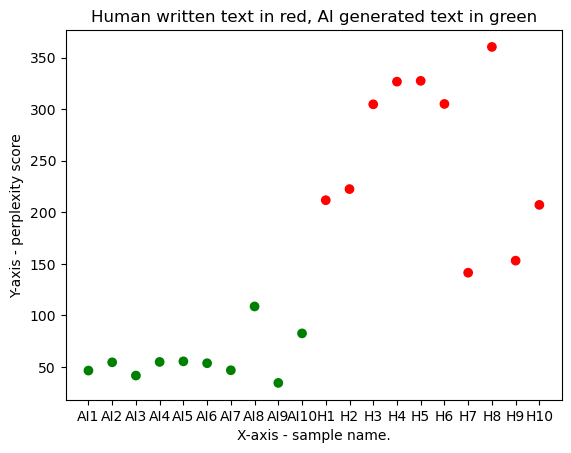

In [196]:
#create the plot
import matplotlib.pyplot as plt
x = ["AI1", "AI2", "AI3", "AI4", "AI5", "AI6","AI7","AI8","AI9","AI10", "H1","H2","H3","H4","H5","H6","H7","H8","H9","H10",]
y = results
colors = ['red' if value > 130 else 'green' for value in y]

# Create scatter plot
plt.scatter(x, y, c=colors)

# Customize plot
plt.title('Human written text in red, AI generated text in green')
plt.xlabel('X-axis - sample name.')
plt.ylabel('Y-axis - perplexity score')

# Display the plot
plt.show()

In this notebook we've compared 10 AI generated texts with 10 texts written by humans and calculated their perplexity. When we plotted the results we see a difference between AI-generated texts (low perplexity) and human written text (high perplexity). 

Without doubt, more testing is needed, especially with other types of text, to get more reliable results.